In [ ]:
!unrar x /content/mnist.rar 

In [ ]:
!pip install watermark

In [11]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch,pandas,numpy,matplotlib

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

torch     : 1.10.0+cu111
pandas    : 1.3.5
numpy     : 1.21.5
matplotlib: 3.2.2



In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv 

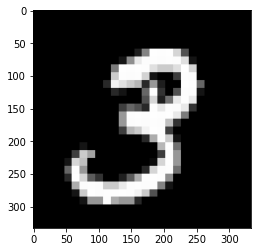

In [26]:
im = Image.open('/content/mnist/train/1.jpg')
plt.imshow(im, cmap='binary')

In [28]:
import numpy as np

# im = cv.cvtColor(im, cv.COLOR_BGR2GRAY) 
im_array = np.array(im)
im_array = im_array[:,:,1]
print('Array Dimensions', im_array.shape)
print()
print(im_array)

Array Dimensions (333, 333)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


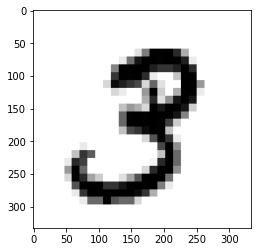

In [29]:
plt.imshow(im_array, cmap='binary')

In [49]:
import pandas as pd
df_train = pd.read_csv('/content/mnist/train/train.csv')
print(df_train.shape)
df_train.head()

(5, 3)


,Class,File,Unnamed: 2
0,1,1.jpg,NaN
1,2,2.jpg,NaN
2,3,3.jpg,NaN
3,4,4.jpg,NaN
4,5,5.jpg,NaN


In [50]:
df_train = pd.DataFrame(df_train)
del df_train["Unnamed: 2"]
df_train

,Class,File
0,1,1.jpg
1,2,2.jpg
2,3,3.jpg
3,4,4.jpg
4,5,5.jpg


In [53]:
df_valid = pd.read_csv('/content/mnist/eval/eval.csv')
print(df_valid.shape)
df_valid.head()
df_valid = pd.DataFrame(df_valid)
del df_valid["Unnamed: 2"]
df_valid

(5, 3)


,Class,File
0,1,1.jpg
1,2,2.jpg
2,3,3.jpg
3,4,4.jpg
4,5,5.jpg


In [57]:
df_test = pd.read_csv('/content/mnist/test/test.csv')
print(df_test.shape)
df_test.head()
df_test = pd.DataFrame(df_test)
del df_test["Unnamed: 2"]
df_test

(5, 3)


,Class,File
0,1,1.jpg
1,2,2.jpg
2,3,3.jpg
3,4,4.jpg
4,5,5.jpg


In [81]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import os


class MyDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['File']
        self.y = df['Class']
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = np.array(img)/255.
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [105]:
from torchvision import transforms
from torch.utils.data import DataLoader


# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.), # not necessary
                                       transforms.ToTensor()
                                      ])

train_dataset = MyDataset(csv_path='/content/mnist/train/train.csv',
                          img_dir='/content/mnist/train',
                          transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=2,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0) # number processes/CPUs to use

In [90]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
       

In [112]:
valid_dataset = MyDataset(csv_path='/content/mnist/eval/eval.csv',
                          img_dir='/content/mnist/eval',
                          transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=2,
                          shuffle=False,
                          num_workers=0)



test_dataset = MyDataset(csv_path='/content/mnist/test/test.csv',
                         img_dir='/content/mnist/test',
                         transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=2,
                         shuffle=False,
                         num_workers=0)

In [106]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

for batch_idx, (x, y) in enumerate(train_loader):

    print(' | Batch index:', batch_idx, end='')
    print(' | Batch size:', y.size()[0])
    
    x = x.to(device)
    y = y.to(device)


 | Batch index: 0 | Batch size: 2
 | Batch index: 1 | Batch size: 2


In [109]:
x.shape

torch.Size([2, 4, 333, 333])

In [111]:
x_image_as_vector = x.view(-1, 333*333)
print(x_image_as_vector.shape)

torch.Size([8, 110889])
